In [2]:
import sys
import os
import math
import random
import heapq 
import time
import copy
import gc
import numpy as np
import pandas as pd
from functools import reduce
from scipy.spatial.distance import pdist
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import baostock as bs#pip install baostock
import mplfinance as mpf #pip install mplfinance
from matplotlib.pylab import date2num
import datetime
torch.cuda.set_device(1)
print (torch.cuda.current_device())

1


In [6]:
#Calculate MACD
def cal_macd_system(data,short_,long_,m):
    '''
    data=['Open','High','Low','Close','Volume']
    parameter: short_,long_,m
    return:data=['Open','High','Low','Close','Volume','diff','dea','macd']
    '''
    data['diff']=data['Close'].ewm(adjust=False,alpha=2/(short_+1),ignore_na=True).mean()-\
                data['Close'].ewm(adjust=False,alpha=2/(long_+1),ignore_na=True).mean()
    data['dea']=data['diff'].ewm(adjust=False,alpha=2/(m+1),ignore_na=True).mean()
    data['macd']=2*(data['diff']-data['dea'])
    return data
def macd_zero(macd):
    pos_signal, neg_signal = [],[]
    for idx,value in macd.iteritems():
        if value > 0:
            pos_signal.append(value)
            neg_signal.append(np.nan)
        else:
            neg_signal.append(value)
            pos_signal.append(np.nan)
    return pos_signal,neg_signal

#generate market chart
lg = bs.login() #login

#read hs300 stocks
rs = bs.query_hs300_stocks() 
hs300_stocks = []
while (rs.error_code == '0') & rs.next():
    hs300_stocks.append(rs.get_row_data())
#read k data
fields= "Date,Code,Open,High,Low,Close,Volume"
period = 160 #20 days
for stock_info in hs300_stocks:
    code=stock_info[1]
    rs = bs.query_history_k_data(code=code, fields=fields, \
                                 start_date='2019-07-01', end_date='2020-03-15', frequency="30",adjustflag="3") 
    data_list = []
    while (rs.error_code == '0') & rs.next():
        data_list.append(rs.get_row_data())
    result = pd.DataFrame(data_list, columns=rs.fields)
    result=result.apply(pd.to_numeric, errors='ignore')
    result = result[['Open','High','Low','Close','Volume']]
    for i in range(result.shape[0]//period): #8 samples per day (30 minutes and 4 hours per day)
        img = result[i*period:(i+1)*period].reset_index(drop=True)
        img.index=pd.to_datetime(img.index)#turn index to datatime
        img = cal_macd_system(img,12,26,9)
        pos_macd, neg_macd  = macd_zero(img['macd']) 
        apds = [ mpf.make_addplot(img['diff'],panel='lower',color='b'),
                 mpf.make_addplot(img['dea'],panel='lower',color='y'),
                 mpf.make_addplot(pos_macd,panel='lower',color='r',scatter=True),
                 mpf.make_addplot(neg_macd,panel='lower',color='g',scatter=True)
               ]
        kwargs = dict(type='candle',figratio =(16,8),volume=False,figscale=1)#line，mav=(5,10)
        save = dict(fname='/data/fjsdata/qtsys/img/'+code+'-'+str(i)+'.png',dpi=100, pad_inches=0.2)
        mpf.plot(img,**kwargs,addplot=apds,style='sas',savefig=save)#charles
        plt.close()
        sys.stdout.write('\r {} / {} '.format(i, result.shape[0]//period))
        sys.stdout.flush()
    print('Stock:%s completed!'%(stock_info[2]))
bs.logout()#logout

login success!
 7 / 8 Stock:浦发银行 completed!
 7 / 8 Stock:白云机场 completed!
 7 / 8 Stock:上海机场 completed!
 7 / 8 Stock:包钢股份 completed!
 7 / 8 Stock:华能国际 completed!
 7 / 8 Stock:华夏银行 completed!
 7 / 8 Stock:民生银行 completed!
 7 / 8 Stock:上港集团 completed!
 7 / 8 Stock:宝钢股份 completed!
 7 / 8 Stock:浙能电力 completed!
 7 / 8 Stock:华能水电 completed!
 7 / 8 Stock:华电国际 completed!
 7 / 8 Stock:中国石化 completed!
 7 / 8 Stock:南方航空 completed!
 7 / 8 Stock:中信证券 completed!
 7 / 8 Stock:三一重工 completed!
 7 / 8 Stock:招商银行 completed!
 7 / 8 Stock:中直股份 completed!
 7 / 8 Stock:保利地产 completed!
 7 / 8 Stock:中国联通 completed!
 7 / 8 Stock:国投资本 completed!
 7 / 8 Stock:宇通客车 completed!
 7 / 8 Stock:葛洲坝 completed!
 7 / 8 Stock:同仁堂 completed!
 7 / 8 Stock:特变电工 completed!
 7 / 8 Stock:同方股份 completed!
 7 / 8 Stock:上汽集团 completed!
 7 / 8 Stock:国金证券 completed!
 7 / 8 Stock:北方稀土 completed!
 7 / 8 Stock:东方航空 completed!
 7 / 8 Stock:中国卫星 completed!
 7 / 8 Stock:建发股份 completed!
 7 / 8 Stock:上海建工 completed!
 7 / 8 Stock:中国巨石 completed!
 

 7 / 8 Stock:网宿科技 completed!
 7 / 8 Stock:机器人 completed!
 7 / 8 Stock:同花顺 completed!
 7 / 8 Stock:东方财富 completed!
 7 / 8 Stock:碧水源 completed!
 7 / 8 Stock:三聚环保 completed!
 7 / 8 Stock:智飞生物 completed!
 7 / 8 Stock:汇川技术 completed!
 7 / 8 Stock:信维通信 completed!
 7 / 8 Stock:沃森生物 completed!
 7 / 8 Stock:宋城演艺 completed!
 7 / 8 Stock:光线传媒 completed!
 7 / 8 Stock:利亚德 completed!
 7 / 8 Stock:三环集团 completed!
 7 / 8 Stock:芒果超媒 completed!
 7 / 8 Stock:蓝思科技 completed!
 7 / 8 Stock:温氏股份 completed!
logout success!


In [11]:
qt_dir = '/data/fjsdata/qtsys/img/' #the path of images
data = []
for iname in os.listdir(qt_dir):
    data.append([iname,''])
df = pd.DataFrame(data,columns=['name','label'])
df.to_csv('/data/fjsdata/qtsys/label.csv',index=False)
data = pd.read_csv('/data/fjsdata/qtsys/label.csv') 
print(data)

                 name  label
0     sh.600000-0.png    NaN
1     sh.600000-1.png    NaN
2     sh.600000-2.png    NaN
3     sh.600000-3.png    NaN
4     sh.600000-4.png    NaN
...               ...    ...
2395  sz.300498-4.png    NaN
2396  sz.300498-5.png    NaN
2397  sz.300498-6.png    NaN
2398  sz.300498-7.png    NaN
2399  sh.600360-0.png    NaN

[2400 rows x 2 columns]


login success!
(160, 5)


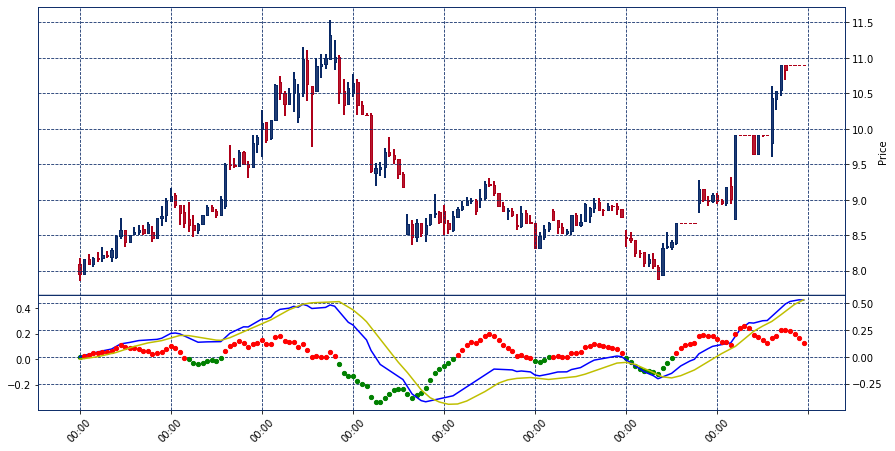

In [8]:
lg = bs.login()
fields= "Date,Code,Open,High,Low,Close,Volume"
rs = bs.query_history_k_data(code="sh.600360", fields=fields, start_date='2020-02-17', end_date='2020-03-15', frequency="30",adjustflag="3") 
data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
result=result.apply(pd.to_numeric, errors='ignore')
result.index=pd.to_datetime(result.index)
#result=result.reset_index()
result = result[['Open','High','Low','Close','Volume']]
print (result.shape)
#get MACD
def cal_macd_system(data,short_,long_,m):
    '''
    data=['Open','High','Low','Close','Volume']
    parameter: short_,long_,m
    return:data=['Open','High','Low','Close','Volume','diff','dea','macd']
    '''
    data['diff']=data['Close'].ewm(adjust=False,alpha=2/(short_+1),ignore_na=True).mean()-\
                data['Close'].ewm(adjust=False,alpha=2/(long_+1),ignore_na=True).mean()
    data['dea']=data['diff'].ewm(adjust=False,alpha=2/(m+1),ignore_na=True).mean()
    data['macd']=2*(data['diff']-data['dea'])
    return data
result = cal_macd_system(result,12,26,9)
def macd_zero(macd):
    pos_signal, neg_signal = [],[]
    for idx,value in macd.iteritems():
        if value > 0:
            pos_signal.append(value)
            neg_signal.append(np.nan)
        else:
            neg_signal.append(value)
            pos_signal.append(np.nan)
    return pos_signal,neg_signal
pos_macd, neg_macd  = macd_zero(result['macd']) 
#plot k line : 
#https://pypi.org/project/mplfinance/  
#https://github.com/matplotlib/mplfinance
apds = [ mpf.make_addplot((result[['diff']]),panel='lower',color='b'),
         mpf.make_addplot((result[['dea']]),panel='lower',color='y'),
         mpf.make_addplot(pos_macd,panel='lower',color='r',scatter=True),
        mpf.make_addplot(neg_macd,panel='lower',color='g',scatter=True)
       ]
kwargs = dict(type='candle',figratio =(16,8),volume=False,figscale=1)#line，mav=(5,10)
save = dict(fname='/data/fjsdata/qtsys/sh.600036-8.png',dpi=100, pad_inches=0.2)
mpf.plot(result,**kwargs,addplot=apds,style='sas',savefig=save)#charles

login success!
         date       code   open   high    low  close
0  2020-03-02  sz.000651  59.10  59.87  59.02  59.61
1  2020-03-02  sz.000651  59.56  59.60  59.20  59.24
2  2020-03-02  sz.000651  59.22  59.30  59.01  59.06
3  2020-03-02  sz.000651  59.06  59.07  58.70  58.90
4  2020-03-02  sz.000651  58.89  59.25  58.87  59.18
(240, 6)


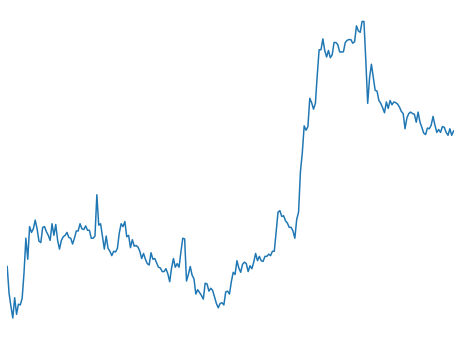

In [13]:
#http://baostock.com/baostock/index.php/Python_API
lg = bs.login()
fields= "date,code,open,high,low,close"
rs = bs.query_history_k_data("sz.000651", fields, start_date='2020-03-02', end_date='2020-03-08', frequency="5", adjustflag="2") 
data_list = []
while (rs.error_code == '0') & rs.next():
    data_list.append(rs.get_row_data())
result = pd.DataFrame(data_list, columns=rs.fields)
#result.index=pd.to_datetime(result.date)
#bs.logout() #exit

#print (result.info())
result=result.apply(pd.to_numeric, errors='ignore') #trun object to numeric
print(result.head())
print(result.shape)

result.close.plot(figsize=(8,6))  
plt.axis('off')
plt.savefig('/data/tmpexec/qt/H2',dpi=200) #(1600=8*200,1200=6*200)
plt.show() 

In [10]:
#pip install tushare
#pip install pyecharts==0.1.9.4
#pip install baostock
import baostock as bs
import tushare as ts
import pandas as pd  
import matplotlib.pyplot as plt
from pylab import mpl
from pyecharts import Kline
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False
tstoken='0519574f81c944a6ff254f438d4e76433dde0265bd064b7d961c240e' #youer token
ts.set_token(tstoken)

In [12]:
#initiate pro api, if token is not saved at local,ts.pro_api(tstoken) can be used as temp token
pro = ts.pro_api()
#https://tushare.pro/document/2?doc_id=25
#basic=pro.stock_basic(list_status='L',exchange='SZSE') #not permit
#print(basic.head())
pa=pro.daily(ts_code='000001.SZ', start_date='20200101',end_date='20200130')
pa.index=pd.to_datetime(pa.trade_date)
pa=pa.sort_index()
t=pa.index
x=list(t.strftime('%Y%m%d')) #x aixs
y=list(pa.loc[:,['open','close','low','high']].values) #y axis
kline = Kline("000001-Kline",title_text_size=15)
kline.add("Day Kline", x, y,
         is_datazoom_show=True,
         mark_line=["average"],
         mark_point=["max", "min"],
         mark_point_symbolsize=60,
         mark_line_valuedim=['highest', 'lowest'] )
kline.render()